In [1]:
from LanguageModels.BERT import BERT
from LanguageModels.Word2Vec import Word2Vec
from LanguageModels.BagOfWords import BagOfWords
from LanguageModels.CustomWord2Vec import CustomWord2Vec
from Preprocessing.DataLoader import DataLoader
from Preprocessing.LemmatizerPreprocessor import LemmatizerPreprocessor
import torch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return 1 / (dot_product / (norm_a * norm_b))

use_cos_sim = True

In [3]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU

In [4]:
lp = LemmatizerPreprocessor()

In [5]:
# Load data
data = DataLoader('../data/EMNLP2020.csv').load()

In [6]:
## Bag Of Words
# lm = BagOfWords()

## Custom word2vec
# lm = CustomWord2Vec('../data/customw2v.p')

## Custom word2vec
# lm = CustomWord2Vec('../data/customw2v_50.p')

## W2V
# lm = Word2Vec(path='../data/glove.6B/glove.6B.200d.txt') 

## Word2Vec Pretrained + Finetuned
# lm = CustomWord2Vec('../data/glove.6B/glove.6B.200d.finetuned.p')

## Bert
lm = BERT(cuda = is_cuda)

## SciBert
# lm = BERT(cuda = is_cuda, path = 'allenai/scibert_scivocab_uncased')


# Multiclass using class descriptions

In [7]:
X_multiclass_bert, y_multiclass_bert = lm.featurize(data, lp, mode='multiclass', remove_neg_samples=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1450/1450 [01:35<00:00, 15.19it/s]


In [8]:
X_multiclass_bert.shape
y_multiclass_bert.shape

(750, 1)

In [9]:
class_descriptions = [
    'Syntax, Phonology, Morphology and Word Segmentation, Linguistic Theories, Cognitive Modeling and Psycholinguistics, Discourse and Pragmatics',
    'Generation & Summarization & Machine Translation and Multilinguality' ,
    'Sentiment Analysis, Stylistic Analysis, and Argument Mining',
    'Machine Learning for NLP and Interpretability and Analysis of Models for NLP',
    'Dialogue, Speech and Interactive Systems + Question Answering',
    'NLP Applications, Language Grounding to Vision, Robotics and Beyond',
    'Computational Social Science and Social Media',
    'Information Extraction & Information Retrieval and Text Mining',
    'Speech and Multimodality',
    'Resources and Evaluation',
]

In [10]:
class_features = []
for i, desc in enumerate(class_descriptions):
    desc_clean = lp.clean(desc)
    class_features.append(lm.convert(desc_clean, method='average'))

class_features = np.array(class_features)
class_features.shape

(10, 768)

In [11]:
# find closest class

y_pred = []
for i, x in enumerate(X_multiclass_bert):
    closest_class = None
    best_dist = np.inf
    
    for j, clas in enumerate(class_features):
        if use_cos_sim:
            dist = cos_sim(x, clas)
        else:
            dist = np.linalg.norm(x - clas)
        
        if dist < best_dist:
            best_dist = dist
            closest_class = j + 1
            
    y_pred.append(closest_class)
    
y_pred = np.array(y_pred)
y_pred.shape

(750,)

In [12]:
print("Accuracy: ", accuracy_score(y_multiclass_bert, y_pred))

Accuracy:  0.2826666666666667


# Multiclass using derived class descriptions

In [13]:
def getSummary(abstracts):
    
    sim_arr = []
    
    #for each abstract calculate the cosine similarity to every other abstract
    for ab in abstracts:
        cos_num = np.dot(abstracts, ab)
        cos_denom = np.linalg.norm(ab) * np.sqrt(np.sum(np.square(abstracts), axis= 1))
        sim_arr.append(np.divide(cos_num, cos_denom))
    
    #for each abstract calculate the average similarity
    sim_avg_arr = np.mean(np.array(sim_arr), axis = 1)
    #get the indices of the top 5 abstracts that are most similar to the rest of the abstracts
    top_5_abstract_inds = sim_avg_arr.argsort()[::-1][:5]
    #take the average of these top 5 abstracts
    class_summary = np.mean(abstracts[top_5_abstract_inds], axis = 0)
    
    return class_summary
    


#for each class generate a summary vector
topic_summaries = []
for i in range(1,11):
    inds = y_multiclass_bert.flatten() == i
    abstracts_i_class = X_multiclass_bert[inds, :]
    i_class_summary = getSummary(abstracts_i_class)
    topic_summaries.append(i_class_summary)
    
topic_summaries = np.array(topic_summaries)

topic_summaries.shape

(10, 768)

In [14]:
# find closest class

y_pred = []
for i, x in enumerate(X_multiclass_bert):
    closest_class = None
    best_dist = np.inf
    
    for j, clas in enumerate(topic_summaries):
        if use_cos_sim:
            dist = cos_sim(x, clas)
        else:
            dist = np.linalg.norm(x - clas)
        
        if dist < best_dist:
            best_dist = dist
            closest_class = j + 1
            
    y_pred.append(closest_class)
    
y_pred = np.array(y_pred)
y_pred.shape

(750,)

In [15]:
print("Accuracy: ", accuracy_score(y_multiclass_bert, y_pred))

Accuracy:  0.32


# Binary classification with threshold classification

In [16]:
X_multiclass_bert, y_multiclass_bert = lm.featurize(data, lp, mode='binary', remove_neg_samples=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1450/1450 [03:07<00:00,  7.72it/s]


In [17]:
# generate one centroid to use for classification

centroid = class_features.mean(axis=0)
centroid.shape

(768,)

In [18]:
X_multiclass_bert_vis = np.vstack((X_multiclass_bert, centroid))
y_multiclass_bert_vis = np.vstack((y_multiclass_bert, 2))

In [19]:
# reduce to 2 dimensions
X_embedded2d = umap.UMAP(n_components=2).fit_transform(X_multiclass_bert_vis)

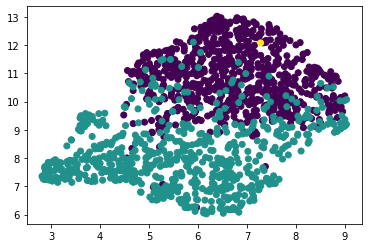

In [20]:
# visualize the space
plt.scatter(X_embedded2d[:,0], X_embedded2d[:,1], c=y_multiclass_bert_vis)

In [21]:
dists = []
for x in X_multiclass_bert:
    if use_cos_sim:
        dists.append(cos_sim(x, centroid))
    else:
        dists.append(np.linalg.norm(x - centroid))
dists = np.array(dists)

## Tuning the threshold value

In [22]:
best_acc = -np.inf
best_threshold = None
best_ypred = None

for threshold in tqdm(np.linspace(min(dists), max(dists), 1000)):
    y_pred = []

    for dist in dists:
        if dist < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_multiclass_bert, y_pred)
    
    if (acc > best_acc):
        best_acc = acc
        best_threshold = threshold
        best_ypred = y_pred
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
print('Best accuracy:', best_acc, 'Best threshold:', best_threshold)

Best accuracy: 0.7379310344827587 Best threshold: 1.4865398115901758


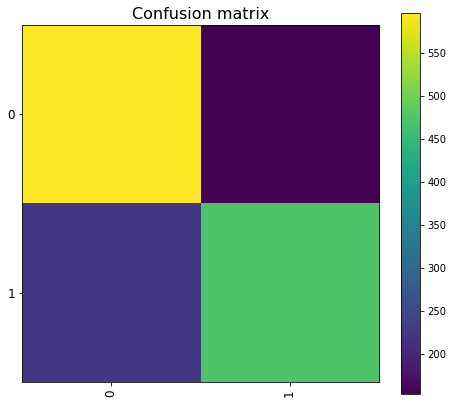

In [24]:
plt.figure(figsize=(8, 7))
plt.imshow(confusion_matrix(y_multiclass_bert, best_ypred))
plt.title('Confusion matrix', fontsize=16)
plt.xticks(np.arange(len(np.unique(y_multiclass_bert))), np.unique(y_multiclass_bert), rotation=90, fontsize=12)
plt.yticks(np.arange(len(np.unique(y_multiclass_bert))), np.unique(y_multiclass_bert), fontsize=12)
plt.colorbar()
plt.show()

# Binary classification with threshold classification (using derived class descriptions)

In [25]:
centroid = topic_summaries.mean(axis=0)
centroid.shape

(768,)

In [26]:
X_multiclass_bert_vis = np.vstack((X_multiclass_bert, centroid))
y_multiclass_bert_vis = np.vstack((y_multiclass_bert, 2))

In [27]:
# reduce to 2 dimensions
X_embedded2d = umap.UMAP(n_components=2).fit_transform(X_multiclass_bert_vis)

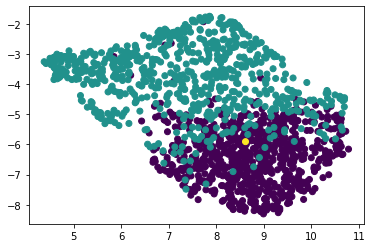

In [28]:
# visualize the space
plt.scatter(X_embedded2d[:,0], X_embedded2d[:,1], c=y_multiclass_bert_vis)

In [29]:
dists = []
for x in X_multiclass_bert:
    if use_cos_sim:
        dists.append(cos_sim(x, centroid))
    else:
        dists.append(np.linalg.norm(x - centroid))
dists = np.array(dists)

In [30]:
best_acc = -np.inf
best_threshold = None
best_ypred = None

for threshold in tqdm(np.linspace(min(dists), max(dists), 1000)):
    y_pred = []

    for dist in dists:
        if dist < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_multiclass_bert, y_pred)
    
    if (acc > best_acc):
        best_acc = acc
        best_threshold = threshold
        best_ypred = y_pred


  0%|          | 0/1000 [00:00<?, ?it/s]

In [31]:
print('Best accuracy:', best_acc, 'Best threshold:', best_threshold)

Best accuracy: 0.8268965517241379 Best threshold: 1.085552081495536


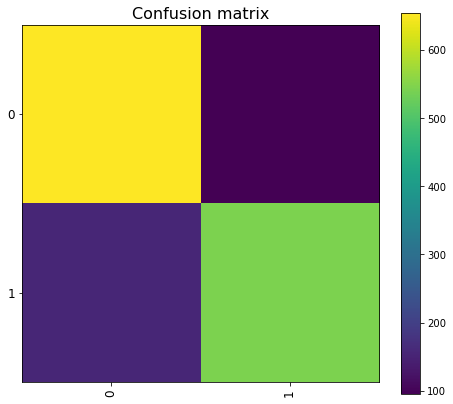

In [32]:
plt.figure(figsize=(8, 7))
plt.imshow(confusion_matrix(y_multiclass_bert, best_ypred))
plt.title('Confusion matrix', fontsize=16)
plt.xticks(np.arange(len(np.unique(y_multiclass_bert))), np.unique(y_multiclass_bert), rotation=90, fontsize=12)
plt.yticks(np.arange(len(np.unique(y_multiclass_bert))), np.unique(y_multiclass_bert), fontsize=12)
plt.colorbar()
plt.show()